In [ ]:
import os
import glob
import requests
import geopandas as gpd
from requests.auth import HTTPBasicAuth
from shapely.geometry import shape
import numpy as np
import subprocess
import json
import pathlib
import pandas as pd
headers = {'Content-Type': 'application/json'}

############# SET THESE VARIABLES ######################
# redefined based on the filter you want to use

from geojson_BUDD_BS import domain 


domainID = 'BUDD_BS'
name = 'BUDD'

# enter the Planet user API key
apiKey = ''
item_type = "PSScene"
asset_type = "ortho_analytic_8b_sr"
bundle_type = "analytic_sr_udm2"
# bundle_type = "analytic_8b_sr_udm2"

# data download location
out_direc= ''
############# DON'T CHANGE VARIABLES BEYOND THIS ############

In [22]:
############ FUNCTIONS. DON'T CHANGE THESE!!! #########
def build_payload(item_ids, item_type, bundle_type, aoi_coordinates):
    payload = {
        "name": item_ids[0],
        "source_type": "scenes",
        "products": [
            {
                "item_ids": item_ids,
                "item_type": item_type,
                "product_bundle": bundle_type
            }
        ],
        "tools": [
            {
                "clip": {
                    "aoi": {
                        "type": "Polygon",
                        "coordinates": aoi_coordinates
                    }
                }
            }
        ]
    }
    return payload

def order_now(payload,apiKey):
    orders_url = 'https://api.planet.com/compute/ops/orders/v2'
    response = requests.post(orders_url, data=json.dumps(payload), auth=HTTPBasicAuth(apiKey, ''), headers=headers)
    print(response)

    if response.status_code==202:
        order_id =response.json()['id']
        url = f"https://api.planet.com/compute/ops/orders/v2/{order_id}"
        # feature_check = requests.get(url, auth=(PLANET_API_KEY, ""))
        feature_check = requests.get(url, auth=HTTPBasicAuth(apiKey, ''))
        if feature_check.status_code==200:
            print(f"Submitted a total of {len(feature_check.json()['products'][0]['item_ids'])} image ids: accepted a total of {len(feature_check.json()['products'][0]['item_ids'])} ids")
            print(f"Order URL: https://api.planet.com/compute/ops/orders/v2/{order_id}")
            return f"https://api.planet.com/compute/ops/orders/v2/{order_id}"
    else:
        print(f'Failed with Exception code : {response.status_code}')
        
def download_results(order_url,folder, overwrite=False):
    r = requests.get(order_url, auth=HTTPBasicAuth(apiKey, ''))
    try:
        if r.status_code ==200:
            response = r.json()
            results = response['_links']['results']
            results_urls = [r['location'] for r in results]
            results_names = [r['name'] for r in results]
            print('{} items to download'.format(len(results_urls)))

            for url, name in zip(results_urls, results_names):
                path = pathlib.Path(os.path.join(folder,name))

                if overwrite or not path.exists():
                    print('downloading {} to {}'.format(name, path))
                    r = requests.get(url, allow_redirects=True)
                    path.parent.mkdir(parents=True, exist_ok=True)
                    open(path, 'wb').write(r.content)
                else:
                    print('{} already exists, skipping {}'.format(path, name))
        else:
            print(f'Failed with response {r.status_code}')
    except:
        print('data not ready yet')
    r.close()
    # except Exception as e:
    #     print(e)
    #     print(order_url)
    #     raise Exception
    # r.close()

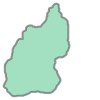

In [23]:
# ensure that the domain shape makes sense
domain_geometry = shape(domain['config'][0]['config'])
domain_geometry

In [24]:
# Search API request object
search_endpoint_request = {
  "item_types": [item_type],
  "filter": domain
}
result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(apiKey, ''),
    json=search_endpoint_request)

In [25]:
# view available data and prepare the list of planet IDs to download
geojson_data = result.json()
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Add a new column to 'gdf' with the intersection area
gdf['intersection_area'] = gdf['geometry'].intersection(domain_geometry).area

# Calculate the percentage overlap
gdf['overlap_percentage'] = (gdf['intersection_area'] / domain_geometry.area) * 100

gdf

,geometry,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,...,snow_ice_percent,strip_id,sun_azimuth,sun_elevation,updated,view_angle,visible_confidence_percent,visible_percent,intersection_area,overlap_percentage
0,"POLYGON ((-119.67211 37.91207, -119.72093 37.7...",2022-09-29T18:19:38.950808Z,0,98,99,0.00,0,True,4.0,0,...,0,5965015,148.5,44.9,2023-03-11T21:26:18Z,4.0,73,100,0.000750,80.905121
1,"POLYGON ((-119.63261 38.05566, -119.68161 37.8...",2022-09-29T18:19:36.655801Z,0,98,99,0.00,0,True,3.9,0,...,0,5965015,148.6,44.8,2023-03-11T21:26:15Z,4.0,73,100,0.000927,100.000000
2,"POLYGON ((-119.35844 37.95633, -119.40887 37.7...",2022-09-28T17:43:08.736288Z,0,97,99,0.00,0,True,4.0,0,...,0,5962706,137.7,41.1,2023-03-22T23:26:22Z,4.9,75,100,0.000309,33.394127
3,"POLYGON ((-119.58361 37.9004, -119.63358 37.72...",2022-09-28T18:01:17.216982Z,0,97,98,0.00,0,True,3.8,0,...,0,5962306,142.6,43.3,2023-03-10T23:04:43Z,4.9,77,100,0.000810,87.444549
4,"POLYGON ((-119.54563 38.04402, -119.59317 37.8...",2022-09-28T18:01:14.935742Z,0,96,97,0.01,1,True,3.8,0,...,0,5962306,142.7,43.2,2023-03-10T23:04:39Z,5.0,75,99,0.000927,99.999728
5,"POLYGON ((-119.42781 37.85695, -119.47562 37.6...",2022-09-28T18:33:23.053042Z,0,96,97,0.01,1,True,3.8,0,...,1,5961951,152.9,46.6,2023-03-22T23:22:32Z,3.0,76,98,0.000420,45.359915
6,"POLYGON ((-119.38994 37.99955, -119.43689 37.8...",2022-09-28T18:33:20.794402Z,0,97,98,0.01,1,True,3.8,0,...,0,5961951,153.0,46.5,2023-03-22T23:22:32Z,3.0,75,99,0.000927,100.000000
7,"POLYGON ((-119.63678 37.92546, -119.68828 37.7...",2022-09-25T18:21:28.743645Z,0,97,99,0.00,0,True,3.9,0,...,1,5955040,146.9,46.0,2023-03-10T23:16:13Z,3.0,76,100,0.000927,100.000000
8,"POLYGON ((-119.59714 38.06773, -119.64852 37.8...",2022-09-25T18:21:26.456426Z,0,97,99,0.00,0,True,3.9,0,...,0,5955040,147.0,45.9,2023-03-10T23:16:11Z,3.0,76,100,0.000824,88.950079
9,"POLYGON ((-119.55486 38.03615, -119.60536 37.8...",2022-09-24T17:42:37.303627Z,0,97,98,0.00,0,True,4.0,0,...,0,5952676,135.9,41.9,2023-03-10T23:13:13Z,5.0,76,100,0.000927,100.000000


In [26]:
# prep the ID and geometry lists
id_list = [feature['id'] for idx, feature in enumerate(geojson_data['features']) if gdf['overlap_percentage'].iloc[idx] >= 55]
geom_list = [feature['geometry'] for idx, feature in enumerate(geojson_data['features']) if gdf['overlap_percentage'].iloc[idx] >= 55]
print(len(id_list))
print(sorted(id_list))

13
['20220916_181939_78_2438', '20220917_181808_88_2483', '20220923_182038_85_247b', '20220924_174237_30_2420', '20220924_174239_59_2420', '20220924_181924_32_248c', '20220925_182126_45_249b', '20220925_182128_74_249b', '20220928_180114_93_225a', '20220928_180117_21_225a', '20220928_183320_79_2426', '20220929_181936_65_2495', '20220929_181938_95_2495']


In [ ]:
### ONLY RUN THIS CELL IF YOU WANT TO CHECK ON ORDER STATUS

# # see the status of the requested tiles. Are they "active"?
# for IDD in id_list:
#     print(IDD)
#     command = 'curl -L -H "Authorization: api-key '+apiKey+'"'
#     sublink = " 'https://api.planet.com/data/v1/item-types/"+item_type+"/items/"+IDD+"/assets/' "
#     # sublink = " 'https://api.planet.com/data/v2/item-types/"+item_type+"/items/"+IDD+"/assets/' "
#     command = command+sublink+'| jq .'+asset_type+'.status'
#     status = subprocess.run(command, shell=True)
#     print(command)
#     # break

In [27]:
# prepare and submit the orders
order_urls = pd.DataFrame(columns = ["index","ID_geom", "order_url"])

# loop through each order payload, and submit
for idx,IDD in enumerate(id_list):
    print(idx,IDD)
    
    payload = build_payload([IDD],item_type,bundle_type,domain['config'][0]['config']['coordinates'])
    order_url = order_now(payload,apiKey)
    
    order_urls.loc[idx, "index"] = idx        
    order_urls.loc[idx, "ID_geom"] = IDD
    order_urls.loc[idx, "order_url"] = order_url

0 20220929_181938_95_2495
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/c4a2aeae-bd62-4455-8b91-1aa193cdab92
1 20220929_181936_65_2495
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/cb74eb3e-6954-4d5f-815b-feca7fe8fd59
2 20220928_180117_21_225a
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/eedd8d18-5cf0-4515-8f1e-6190cf186d03
3 20220928_180114_93_225a
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/1d5f0773-4b4e-4e47-8d1b-59c261009188
4 20220928_183320_79_2426
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/86ad9986-d256-4885-82dd-9c9b22de9d13
5 20220925_182128_74

In [28]:
# check out the data, save to a csv if you want to come back later
print(order_urls)
order_urls.to_csv('8b_BUDD_urlSaver_2022.csv', index = None)# save all URLs

   index                  ID_geom  \
0      0  20220929_181938_95_2495   
1      1  20220929_181936_65_2495   
2      2  20220928_180117_21_225a   
3      3  20220928_180114_93_225a   
4      4  20220928_183320_79_2426   
5      5  20220925_182128_74_249b   
6      6  20220925_182126_45_249b   
7      7  20220924_174237_30_2420   
8      8  20220924_181924_32_248c   
9      9  20220924_174239_59_2420   
10    10  20220923_182038_85_247b   
11    11  20220917_181808_88_2483   
12    12  20220916_181939_78_2438   

                                            order_url  
0   https://api.planet.com/compute/ops/orders/v2/c...  
1   https://api.planet.com/compute/ops/orders/v2/c...  
2   https://api.planet.com/compute/ops/orders/v2/e...  
3   https://api.planet.com/compute/ops/orders/v2/1...  
4   https://api.planet.com/compute/ops/orders/v2/8...  
5   https://api.planet.com/compute/ops/orders/v2/1...  
6   https://api.planet.com/compute/ops/orders/v2/7...  
7   https://api.planet.com/comput

In [ ]:
# Check this duplicates order I think
# create or add to URL saver csv
# url_saver = f'{name}_urlSaver.csv'

# if not os.path.exists(url_saver):
#     print(order_urls)
#     order_urls.to_csv(url_saver, index=None)  # Save all URLs
# else:
#     # If downloading dates separately, save the order_urls to already created csv when running for the first time
#     existing_urls = pd.read_csv(url_saver)
#     updated_urls = pd.concat([existing_urls, order_urls], ignore_index=True)
#     updated_urls.to_csv(url_saver, index=None)

In [9]:
order_urls = pd.read_csv('BUDD_urlSaver_2020.csv')

In [33]:
# download the orders once ready
# outputs of "data not ready yet" mean that the orders need more time to process before downloading
for url in order_urls.itertuples():
    print(url.index,url.order_url)
    print("start downloading data to".format(), out_direc + url.ID_geom)
    if url.order_url != None:
        try:
            nantest = ~np.isnan(url.order_url)
        except:
            download_results(url.order_url,folder = out_direc + url.ID_geom)
    # break

0 https://api.planet.com/compute/ops/orders/v2/c4a2aeae-bd62-4455-8b91-1aa193cdab92
start downloading data to /home/etboud/projects/data/planet/ndvi_8B/20220929_181938_95_2495
5 items to download
/home/etboud/projects/data/planet/ndvi_8B/20220929_181938_95_2495/c4a2aeae-bd62-4455-8b91-1aa193cdab92/PSScene/20220929_181938_95_2495_metadata.json already exists, skipping c4a2aeae-bd62-4455-8b91-1aa193cdab92/PSScene/20220929_181938_95_2495_metadata.json
/home/etboud/projects/data/planet/ndvi_8B/20220929_181938_95_2495/c4a2aeae-bd62-4455-8b91-1aa193cdab92/PSScene/20220929_181938_95_2495_3B_AnalyticMS_SR_8b_clip.tif already exists, skipping c4a2aeae-bd62-4455-8b91-1aa193cdab92/PSScene/20220929_181938_95_2495_3B_AnalyticMS_SR_8b_clip.tif
/home/etboud/projects/data/planet/ndvi_8B/20220929_181938_95_2495/c4a2aeae-bd62-4455-8b91-1aa193cdab92/PSScene/20220929_181938_95_2495_3B_udm2_clip.tif already exists, skipping c4a2aeae-bd62-4455-8b91-1aa193cdab92/PSScene/20220929_181938_95_2495_3B_udm2_clip.t